In [14]:
import os, sys, subprocess, fitsio
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)

Paths and filenames with the observational data

In [4]:
paths = {"targets": "/project/projectdirs/desi/target/catalogs/dr7.1/PR372/", 
         "skies": "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
         "gfas": "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

names = {"targets": "dr7.1-PR372.fits", "skies":"dr7.1-0.22.0.fits", "gfas": "dr7.1.fits"}

Some more files needed to run fiberassign

In [34]:
mtlfile = os.path.join(workdir, 'mtl.fits')
truthfile = os.path.join(workdir, 'truth.fits')
starfile = os.path.join(workdir, 'std.fits')
targetcutfile = os.path.join(workdir, 'targets.fits') 
skycutfile = os.path.join(workdir, 'sky.fits') 
targetfile = os.path.join(paths["targets"], "targets-{}".format(names["targets"]))
skyfile = os.path.join(paths["skies"], "skies-{}".format(names["skies"]))
gfafile = os.path.join(paths["gfas"], "gfas-{}".format(names["gfas"]))
tilefile = os.path.join(workdir, "tiles.fits")

In [35]:
# tile selection
program = "dark"

tiles = desimodel.io.load_tiles()
bright = tiles['PROGRAM']=='BRIGHT'
    
small = ((tiles['RA']>12) & (tiles['RA']<20) & (tiles['DEC']<1) & (tiles['DEC']>-1))

if program=="bright":
    Table(tiles[(bright)&(small)]).write(tilefile, overwrite=True)
else:
    Table(tiles[(~bright) & (small)]).write(tilefile, overwrite=True)

print("Wrote tiles to {}".format(tilefile))

Wrote tiles to /global/cscratch1/sd/forero/desi/test/fiberassign/tiles.fits


In [17]:
# target selection
if (not os.path.exists(mtlfile)) or (not os.path.exists(starfile) or (not os.path.exists(truthfile)) or (not os.path.exists(targetcutfile))):
    print('Started reading {}'.format(targetfile))
    targetdata = fitsio.read(targetfile, 'TARGETS')
    ii = (targetdata['RA']>10) &  (targetdata['RA']<22) & (targetdata['DEC']<3) & (targetdata['DEC']>-3)
    targetdata = targetdata[ii]
    print('Done reading target data to compute mtl + star')

Started reading /project/projectdirs/desi/target/catalogs/dr7.1/PR372/targets-dr7.1-PR372.fits
Done reading target data to compute mtl + star


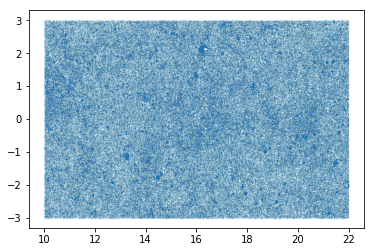

In [18]:
plt.scatter(targetdata['RA'], targetdata['DEC'],s=0.1, alpha=0.1)

In [19]:
# compute targetcut file

if (not os.path.exists(targetcutfile)):
    Table(targetdata).write(targetcutfile, overwrite=True)
    print('Done writing target cut data')

Done writing target cut data


In [22]:
# compute skycut file
if (not os.path.exists(skycutfile)):
    skydata = fitsio.read(skyfile)
    ii = (skydata['RA']>10) &  (skydata['RA']<22) & (skydata['DEC']<3) & (skydata['DEC']>-3)
    skydata = skydata[ii]
    Table(skydata).write(skycutfile, overwrite=True)
    print('Done writing sky cut data')

Done writing sky cut data


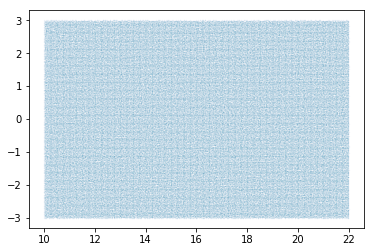

In [23]:
plt.scatter(skydata['RA'], skydata['DEC'],s=0.1, alpha=0.1)

In [24]:
#standards
if not os.path.exists(starfile):
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    starstd = (targetdata['DESI_TARGET'] & std_mask) != 0
    stardata = targetdata[starstd]

    if program=="bright":
        obscond = np.int_(np.repeat(obsconditions['BRIGHT'], len(stardata)))
    else:
        obscond = np.int_(np.repeat(obsconditions['DARK']|obsconditions['GRAY'], len(stardata))) 

    stardata = np.lib.recfunctions.append_fields(stardata, 'OBSCONDITIONS', obscond)  
        
    ii = (stardata['RA']>10) &  (stardata['RA']<22) & (stardata['DEC']<3) & (stardata['DEC']>-3)
    stardata = stardata[ii]
        
    fitsio.write(starfile, stardata, extname='STD')
    print('{} standards'.format(np.count_nonzero(stardata)))
    print('Finished with standards')

4678 standards
Finished with standards


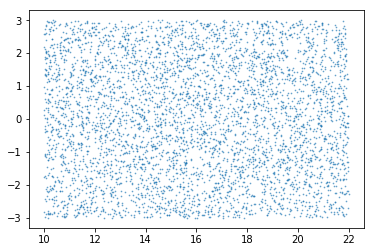

In [29]:
plt.scatter(stardata['RA'], stardata['DEC'],s=0.5, alpha=0.6)

In [31]:
#compute MTL
if not os.path.exists(mtlfile):
    print('computing mtl')
    import desitarget.mtl
    mtl = desitarget.mtl.make_mtl(targetdata)

    # only include BGS and MWS
    isbgsmws = ((mtl['BGS_TARGET']!=0) | (mtl['MWS_TARGET']!=0))
    if program=="bright":
        mtl = mtl[isbgsmws]
    else:
        mtl = mtl[~isbgsmws]


    mtl.meta['EXTNAME'] = 'MTL'
    mtl.write(mtlfile)
    
    #print some stats
    print('MWS_TARGETS: {}'.format(np.count_nonzero(mtl['MWS_TARGET']!=0)))
    print('BGS_TARGETS: {}'.format(np.count_nonzero(mtl['BGS_TARGET']!=0)))
    print('DESI_TARGETS: {}'.format(np.count_nonzero(mtl['DESI_TARGET']!=0)))
    print('finished computing mtl')

computing mtl
INFO:mtl.py:87:make_mtl: 683 of 484445 targets have priority zero, setting N_obs=0.
MWS_TARGETS: 0
BGS_TARGETS: 0
DESI_TARGETS: 297129
finished computing mtl


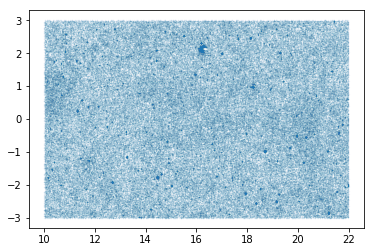

In [33]:
plt.scatter(mtl['RA'], mtl['DEC'], s=0.1, alpha=0.1)

In [36]:
cmd = 'fiberassign --mtl mtl.fits --stdstar std.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)
print(cmd)

fiberassign --mtl mtl.fits --stdstar std.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/


In [37]:
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: fiberassign --mtl mtl.fits --stdstar std.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/
0


In [38]:
!ls output

tile_00543.fits  tile_06306.fits  tile_13111.fits  tile_23589.fits
tile_00544.fits  tile_07349.fits  tile_17827.fits  tile_24633.fits
tile_01587.fits  tile_12065.fits  tile_17829.fits  tile_24635.fits
tile_06305.fits  tile_12067.fits  tile_18873.fits


In [41]:
tiles = Table.read("tiles.fits")
targets = Table.read("mtl.fits")

In [45]:
tilefile = '{}/tile_{:05d}.fits'.format(outdir, tiles['TILEID'][0])
fx = fits.open(tilefile)
print(fx.info())
print('\nFIBERASSIGN columns:')
print(fx['FIBERASSIGN'].data.dtype.names)
print('\nPOTENTIAL columns:')
print(fx['POTENTIAL'].data.dtype.names)
fx.close()

Filename: /global/cscratch1/sd/forero/desi/test/fiberassign/output/tile_00543.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  FIBERASSIGN    1 BinTableHDU    225   5000R x 108C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J, E, E, E, 3A, I, J, J, J, J, 4A, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, E, E, E, E, E, E, E, L, E, E, E, E, E, E, L, 1A, D, K, J, J]   
  2  POTENTIAL     1 BinTableHDU     15   54557R x 3C   [K, J, J]   
  3  SKYETC        1 BinTableHDU     37   20R x 14C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J]   
  4  TARGETS       1 BinTableHDU    201   5000R x 96C   [K, J, J, 8A, J, 4A, D, D, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 

Text(0.5,1,'Targets assigned to fibers')

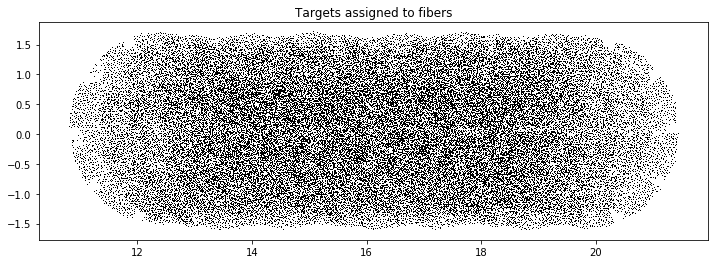

In [46]:
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile_{:05d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, 'FIBERASSIGN'))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(12,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
# plot_tiles(tiles)